In [1]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

In [2]:
vest_mo_18 = gp.read_file("./raw-from-source/VEST/mo_2018/mo_2018.shp")

## Election Data Sources

Election results from the Secretary of State's office via OpenElections (https://github.com/openelections/openelections-data-mo/tree/master/2018). Absentee, provisional, and mail ballots were reported countywide in nearly every county; these were distributed by candidate to precincts based on their share of the precinct-level reported vote.

- G18USSRHAW - Josh Hawley (Republican Party)  
- G18USSDMCC - Claire McCaskill (Democratic Party)  
- G18USSLCAM - Japheth Campbell (Libertarian Party)  
- G18USSGCRA - Jo Crain (Green Party)  
- G18USSIODE - Craig O'Dear (Independent)  
  
  
- G18AUDRMCD - Saundra McDowell (Republican Party)  
- G18AUDDGAL - Nicole Galloway (Democratic Party)  
- G18AUDLOTO - Sean O'Toole (Libertarian Party)  
- G18AUDGFIT - Don Fitz (Green Party)  
- G18AUDCLUE - Jacob Luetkemeyer (Constitution Party)  


In [43]:
mo_elections = pd.read_csv("./raw-from-source/Open_Elections/20181106__mo__general__precinct.csv")
candidate_list = ['Josh Hawley','Claire McCaskill','Japheth Campbell','Jo Crain',
 "Craig O'Dear",'Saundra McDowell','Nicole Galloway',"Sean O'Toole",'Don Fitz','Jacob Luetkemeyer']
office_list = ['U.S. Senate', 'State Auditor']
mo_elections["candidate"] = mo_elections["candidate"].str.strip()
mo_elections = mo_elections[mo_elections["office"].isin(office_list)]
mo_elections = mo_elections[mo_elections["candidate"].isin(candidate_list)]


In [82]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Missouri"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
#print(fips_file[~fips_file["County Name"].isin(mo_elections["county"])]["County Name"].unique())
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
mo_changes = {'De Kalb':'Dekalb','Kansas City':'Jackson','McDonald':'Mcdonald',
              'St. Charles':'St Charles','St. Clair':'St Clair',
              'Ste. Genevieve':'Ste Genevieve','St. Francois':'St Francois',
              'St. Louis City':'St Louis City','St. Louis County':'St Louis'}
mo_elections['county'] = mo_elections['county'].map(mo_changes).fillna(mo_elections['county'])
mo_elections['COUNTYFP'] = mo_elections['county'].map(fips_dict).fillna(mo_elections['county'])
mo_elections["unique_ID"]=mo_elections["COUNTYFP"]+mo_elections["precinct"]

In [45]:
mo_elections_pivot = pd.pivot_table(mo_elections,index=["unique_ID","COUNTYFP","precinct"],columns=["candidate"],values=['votes'],aggfunc=sum)
mo_elections_pivot = mo_elections_pivot.fillna(0)
mo_elections_pivot.columns = mo_elections_pivot.columns.droplevel(0)
mo_elections_pivot.reset_index(drop=False,inplace=True)
print(mo_elections_pivot.head())

candidate       unique_ID COUNTYFP     precinct  Claire McCaskill  \
0             001ABSENTEE      001     ABSENTEE             428.0   
1             001BRASHEAR      001     BRASHEAR             170.0   
2              001FEDERAL      001      FEDERAL               0.0   
3          001NORTHEAST 5      001  NORTHEAST 5             277.0   
4          001NORTHEAST 6      001  NORTHEAST 6             365.0   

candidate  Craig O'Dear  Don Fitz  Jacob Luetkemeyer  Japheth Campbell  \
0                  11.0       5.0               33.0               9.0   
1                  17.0       4.0               26.0               7.0   
2                   0.0       0.0                0.0               0.0   
3                   7.0       7.0               21.0               4.0   
4                  10.0      13.0               20.0               5.0   

candidate  Jo Crain  Josh Hawley  Nicole Galloway  Saundra McDowell  \
0               5.0        601.0            438.0             527.0  

In [46]:
mo_elections_pivot = mo_elections_pivot.rename(columns={'Claire McCaskill':"G18USSDMCC",
                           "Craig O'Dear": "G18USSIODE",
                           'Don Fitz':"G18AUDGFIT",
                           'Jacob Luetkemeyer':"G18AUDCLUE",
                           'Japheth Campbell':"G18USSLCAM",
                           'Jo Crain':"G18USSGCRA",
                           'Josh Hawley':"G18USSRHAW",
                           'Nicole Galloway':"G18AUDDGAL",
                           'Saundra McDowell':"G18AUDRMCD",
                           "Sean O'Toole":"G18AUDLOTO"})



In [48]:
print(mo_elections_pivot.head())
remove_list = ["ABSENTEE","PROVISIONAL","FEDERAL"]
mo_elections_countywide = mo_elections_pivot[mo_elections_pivot["precinct"].isin(remove_list)]
mo_elections_pivot = mo_elections_pivot[~mo_elections_pivot["precinct"].isin(remove_list)]
print(mo_elections_countywide.head())
print(mo_elections_pivot.head())

candidate       unique_ID COUNTYFP     precinct  G18USSDMCC  G18USSIODE  \
0             001ABSENTEE      001     ABSENTEE       428.0        11.0   
1             001BRASHEAR      001     BRASHEAR       170.0        17.0   
2              001FEDERAL      001      FEDERAL         0.0         0.0   
3          001NORTHEAST 5      001  NORTHEAST 5       277.0         7.0   
4          001NORTHEAST 6      001  NORTHEAST 6       365.0        10.0   

candidate  G18AUDGFIT  G18AUDCLUE  G18USSLCAM  G18USSGCRA  G18USSRHAW  \
0                 5.0        33.0         9.0         5.0       601.0   
1                 4.0        26.0         7.0         3.0       507.0   
2                 0.0         0.0         0.0         0.0         2.0   
3                 7.0        21.0         4.0         4.0       375.0   
4                13.0        20.0         5.0         3.0       516.0   

candidate  G18AUDDGAL  G18AUDRMCD  G18AUDLOTO  
0               438.0       527.0        17.0  
1             

In [56]:
countywide_totals = mo_elections_countywide.groupby(["COUNTYFP"]).sum()
precinct_totals = mo_elections_pivot.groupby(["COUNTYFP"]).sum()

In [72]:
data_to_add = pd.merge(countywide_totals,precinct_totals,on=['COUNTYFP'],how='outer',indicator=False)
joined = pd.merge(mo_elections_pivot,data_to_add,on=['COUNTYFP'],how='left',indicator=False)
joined = joined.fillna(0)
col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
for i in col_list:
    countywide = i + "_x"
    total = i+"_y"
    joined[i]=joined[i].apply(lambda x:round(((x/joined[total])*(joined[countywide])) + x))
joined = joined[["unique_ID","COUNTYFP","precinct","G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]]
print(joined.head())

candidate        unique_ID COUNTYFP      precinct  G18USSDMCC  G18USSIODE  \
0              001BRASHEAR      001      BRASHEAR       170.0        17.0   
1           001NORTHEAST 5      001   NORTHEAST 5       277.0         7.0   
2           001NORTHEAST 6      001   NORTHEAST 6       365.0        10.0   
3              001NOVINGER      001      NOVINGER       189.0        15.0   
4          001RURAL BENTON      001  RURAL BENTON       418.0        15.0   

candidate  G18AUDGFIT  G18AUDCLUE  G18USSLCAM  G18USSGCRA  G18USSRHAW  ...  \
0                 4.0        26.0         7.0         3.0       507.0  ...   
1                 7.0        21.0         4.0         4.0       375.0  ...   
2                13.0        20.0         5.0         3.0       516.0  ...   
3                 7.0        24.0         7.0         4.0       593.0  ...   
4                 7.0        47.0        12.0         7.0       933.0  ...   

candidate  G18USSDMCC_y  G18USSIODE_y  G18AUDGFIT_y  G18AUDCLUE_y  \

- G18USSRHAW - Josh Hawley (Republican Party)  
- G18USSDMCC - Claire McCaskill (Democratic Party)  
- G18USSLCAM - Japheth Campbell (Libertarian Party)  
- G18USSGCRA - Jo Crain (Green Party)  
- G18USSIODE - Craig O'Dear (Independent)  
  
  
- G18AUDRMCD - Saundra McDowell (Republican Party)  
- G18AUDDGAL - Nicole Galloway (Democratic Party)  
- G18AUDLOTO - Sean O'Toole (Libertarian Party)  
- G18AUDGFIT - Don Fitz (Green Party)  
- G18AUDCLUE - Jacob Luetkemeyer (Constitution Party)  

In [131]:
print(vest_mo_18.head())
vest_mo_18["unique_ID"]=vest_mo_18["COUNTYFP"]+vest_mo_18["NAME"]
final_join = pd.merge(vest_mo_18,joined,how="outer",on="unique_ID",indicator=True)
print(final_join["_merge"].value_counts())
final_join[final_join["_merge"]=="right_only"].to_csv("./election_only.csv")
final_join[final_join["_merge"]=="left_only"].to_csv("./VEST_only.csv")

  STATEFP COUNTYFP           NAME  G18USSRHAW  G18USSDMCC  G18USSLCAM  \
0      29      189          MR032          77          26           0   
1      29      189  CHE044/LAF001         254         288           2   
2      29      201       Commerce         215          89           1   
3      29      043    West Finley        1254         504          34   
4      29      189  MID036/MID048          48         257           1   

   G18USSGCRA  G18USSIODE  G18AUDRMCD  G18AUDDGAL  G18AUDLOTO  G18AUDGFIT  \
0           0           0          57          42           0           0   
1           2           2         227         303           7           0   
2           0           0         197          89           5           0   
3          14          38        1056         651          67          15   
4           4           9          37         268           5           4   

   G18AUDCLUE                                           geometry  \
0           2  POLYGON ((-90.5

## Precinct Shapefile Sources

The documentation mentions 4 different sources for shapefiles:

1. Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.  
2. Monroe County comes from the 2010 Census VTD release.  
3. Platte County comes from the 2020 Census VTD release.  
4. The following counties instead used maps or shapefiles sourced from the respective county governments: Audrain, Bates, Caldwell, Callaway, Camden, Cape Girardeau, Cedar, Cooper, Franklin, Greene, Jackson, Jasper, Jefferson, Laclede, Lafayette, Lawrence, Marion, McDonald, Miller, Nodaway, Osage, Ozark, Pemiscot, Pike, Randolph, Scott, Ste. Genevieve, Texas, Warren, Washington, Worth, Wright.  

In [100]:
print(fips_file[fips_file["County Name"]=="Platte"])

         State County Name  FIPS State FIPS County unique_ID
1562  Missouri      Platte          29         165     29165


### 1. U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release
> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

https://www.census.gov/geo/partnerships/pvs/partnership19v2/st29_mo.html

In [91]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties

fips_file["unique_ID"] =  "29" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/2020_Phase_2/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)
print(shapefiles_census.shape)

(4607, 16)


In [115]:
print(shapefiles_census.head())

  STATEFP COUNTYFP   VTDST                     NAMELSAD VTDI LSAD CHNG_TYPE  \
0      29      001  000002     Brashear Voting District    P   V2      None   
1      29      001  000003  Northeast 4 Voting District    P   V2      None   
2      29      001  000004  Northeast 5 Voting District    P   V2      None   
3      29      001  000005  Northeast 6 Voting District    P   V2      None   
4      29      001  000006     Novinger Voting District    P   V2      None   

  ORIG_NAME ORIG_CODE RELATE         NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
0      None      None   None     Brashear      90        S    None  G5240   
1      None      None   None  Northeast 4      90        S    None  G5240   
2      None      None   None  Northeast 5      90        S    None  G5240   
3      None      None   None  Northeast 6      90        S    None  G5240   
4      None      None   None     Novinger      90        S    None  G5240   

                                            geometry  
0  POLY

In [119]:
#print(shapefiles_census.head())
county_list = ["Audrain", "Bates","Caldwell","Callaway","Camden","Cape Girardeau","Cedar","Cooper","Franklin","Greene","Jackson","Jasper","Jefferson", 
               "Laclede", "Lafayette","Lawrence", "Marion", "Mcdonald","Miller","Monroe","Nodaway",
               "Osage", "Ozark", "Pemiscot","Platte", "Pike", "Randolph", "Scott","Ste Genevieve", "Texas", "Warren", "Washington", "Worth", "Wright"]
print(len(county_list))
fips_to_take = fips_file[fips_file["County Name"].isin(county_list)]
different_source = fips_to_take["FIPS County"].tolist()
print(different_source)

shapefiles_census = shapefiles_census[~shapefiles_census["COUNTYFP"].isin(different_source)]

34
['007', '013', '025', '027', '029', '031', '039', '053', '071', '077', '095', '097', '099', '105', '107', '109', '119', '127', '131', '137', '147', '151', '153', '155', '163', '165', '175', '186', '201', '215', '219', '221', '227', '229']


### 2. 2010 Census VTD release
>Monroe County comes from the 2010 Census VTD release.

https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Voting+Districts

In [95]:
monroe_shape = gp.read_file("./raw-from-source/Census/2010_VTD/tl_2010_29137_vtd10/tl_2010_29137_vtd10.shp")

### 3. 2020 Census VTD release
>Platte County comes from the 2020 Census VTD release.

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html

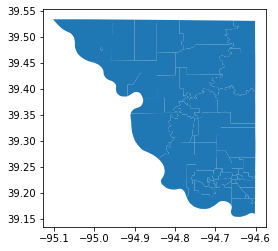

In [97]:
platte_shape = gp.read_file("./raw-from-source/Census/2020_VTD/tl_2020_29_all/tl_2020_29165_vtd20.shp")
platte_shape.plot()

### 4. Counties themselves
> The following counties instead used maps or shapefiles sourced from the respective county governments:  
Audrain, Bates, Caldwell, Callaway, Camden, Cape Girardeau, Cedar, Cooper, Franklin, Greene, Jackson, Jasper, Jefferson, Laclede, Lafayette, Lawrence, Marion, McDonald, Miller, Nodaway, Osage, Ozark, Pemiscot, Pike, Randolph, Scott, Ste. Genevieve, Texas, Warren, Washington, Worth, Wright.  

- Audrain: https://audraingis.integritygis.com/H5/Index.html?viewer=audrain
- Bates: https://batesgis.integritygis.com/H5/Index.html?viewer=bates
- Caldwell: can't find
- Callaway: can't find
- Camden: https://camdengis.integritygis.com/H5/Index.html?viewer=camden
- Cape Girardeau: only pdf (https://capecountyelections.com/wp-content/uploads/2019/06/Voter_Precincts.pdf)
- Cedar: can't find
- Cooper
- Franklin
- Greene
- Jackson
- Jasper
- Jefferson
- Laclede
- Lafayette
- Lawrence
- Marion
- McDonald
- Miller
- Nodaway
- Osage
- Ozark
- Pemiscot
- Pike
- Randolph
- Scott
- Ste. Genevieve
- Texas
- Warren
- Washington
- Worth
- Wright

Missouri
--------

Precinct mergers were made in the following counties to match county reporting units: Andrew, Audrain, Barry, Benton, Bollinger, Boone, Callaway, Camden, Cape Girardeau, Carroll, Carter, Cass, Christian, Clark, Cole, Cooper, Crawford, Dallas, Dekalb, Douglas, Dunklin, Franklin, Gentry, Greene, Grundy, Holt, Howard, Howell, Jackson, Jasper, Jefferson, Johnson, Linn, Livingston, Marion, Mercer, Mississippi, Moniteau, Morgan, New Madrid, Nodaway, Oregon, Osage, Pemiscot, Pettis, Phelps, Platte, Polk, Putnam, Ralls, Randolph, Ray, Ripley, St. Clair, St. Francois, St. Louis, Schuyler, Shannon, Shelby, Stoddard, Sullivan, Warren, Wayne, Webster, Worth.

Additional modifications to reflect how election results were reported in 2018:

- Audrain: Add Vandalia City; Align Mexico precincts with municipal code
- Barry: Add Monett City; Align Cassville with corporate boundary
- Barton: Adjust Lamar ward boundaries to match city map
- Bollinger: Adjust Patton/Sedgewickville to match county GIS
- Butler: Align Poplar Bluff with corporate boundary and adjust wards to match city map
- Callaway: Align Fulton, Holts Summit precincts with 2018 corporate boundaries
- Carroll: Adjust Carrollton City wards to match voter file
- Cass: Align Belton, Pleasant Hill, Raymore precincts with corporate boundaries; Adjust 37 Pleasant Prairie/25 West Peculiar Rural
- Chariton: Adjust Salisbury wards to match city map
- Christian: Revise Cassidy 1/Cassidy 2; Reverse Nixa City annexation into Rosedale 1B
- Clay: Adjust Excelsior Springs, Kearney, Smithville precincts to match 2018 ward and corporate boundaries; Adjust KC 21-1/15, 21-1/17, 21-3/11, 21-4/6, 21-4/11, 21-5/7/24, 21-6/24, 21-7/20, 21-13/26, 21-14/23, 21-17/16, 21-17/26, 21-17/Platte 1, Gallatin 7/16, 10/13, 10/16, 11/15, 13/15, Kearney 3/Platte 2, Liberty 1/10, 6/13, 7/11, 11/14, Washington 1/3 to match voter file
- Clinton: Align Atchison/Concord, Jackson/Lathrop with 2018 precinct split assignments
- Cole: Adjust Marion Twp St Martins to include St Martins city in Jefferson Twp
- Crawford: Move Benton Twp section of Leasburg precinct from Recklein to Leasburg
- Dade: Realign Greenfield wards to match municipal code
- Dallas: Split N Benton Inside/OCL, S Benton Inside/OCL; Align N/S Benton with Buffalo ward map
- Dent: Split Boss precinct from R-4 precinct; Adjust R-2/R-3 boundary
- Dunklin: Align Holcomb, Rives with township boundaries; Adjust Arbyrd/Senath; Align Kennett wards with city map
- Franklin: Split Dry Branch between Stanton & St. Clair Out of Town
- Gasconade: Align Hermann, Owensville, Rosebud with corporate boundaries and ward descriptions
- Holt: Split West between Central/Northwest by school district
- Howell: Align West Plains precincts with 2018 corporate boundary
- Iron: Adjust Annapolis/Des Arc/Vulcan, Ironton/Pilot Knob
- Jasper: Realign Carthage 2/3, Joplin 1/7, 10/13, 10/15, 13/22, Oronogo 1/2, Webb City 1/4 to match city ward maps
- Jefferson: Split Festus Ward 1 P1/P2, Ward 3 P1/P2, Ward 4 P1/P2; Adjust Crystal City/Riverview
- Johnson: Adjust Warrensburg NE/NW boundary to match county maps
- Lewis: Split LaBelle Twp between LaBelle FS/Lewistown FS with PLSS grid
- Lincoln: Align Moscow Mills, Troy with 2018 corporate boundaries; Adjust Briscoe/Troy Rural
- Linn: Split Brookfield Township between Brookfield 1&2/3&4
- Livingston: Align Chillicothe with 2018 corporate boundaries
- Macon: Align Macon City wards with corporate boundaries
- Madison: Align Fredericktown wards with corporate boundaries
- Marion: Split Fabius-Smileyville/Taylor, Warren-Monroe City/Warren; Align Hannibal wards with voter file
- Miller: Adjust all precinct boundaries to match voter file
- Mississippi: Adjust Bertrand/East Prairie Rural; Align East Prairie City with corporate boundary
- Montgomery: Align Bellflower/Middletown, Big Spring/Rhineland with voter file
- Morgan: Adjust Versaille North/South boundary to match county GIS
- New Madrid: Add New Madrid City wards; Add Big Prairie 4 precinct; Move Portageville Ward 1 to Portage 1
- Newton: Align Staples precincts with Joplin City GIS boundaries; Align Neosho precincts with Neosho City GIS boundaries; Adjust Newtonia/Ritchey Wentworth
- Pettis: Adjust Sedalia City wards to match city map
- Phelps: Align St. James ward boundaries with city map
- Pike: Adjust Cuivre JL boundaries with Ashley NO, Buffalo E, Prairieville I
- Platte: Align Lake Waukomis, Parkville, Platte City, Riverside/Northmore, Weatherby Lake with corporate boundaries; Adjust Platte Hills/Park Hill, Seven Bridges/Shiloh
- Polk: Split Campbell/Jefferson precincts by school district
- Pulaski: Adjust Big Piney/St. Roberts, Laquey/Waynesville
- Putnam: Split Union Twp into NE/SW precincts to match county map
- Ralls: Replace Center/Liberty precincts with 2010 VTDs
- Ray: Adjust Richmond City wards, Homestead Village/Wood Heights/Lawson, Richmond/Orrick
- Reynolds: Realign precincts countywide to match voter file
- Saline: Split Nelson precinct from Hardeman precinct; Adjust Marshall Ward 2/3 boundary
- St. Charles: Adjust Brian/Ridgepoint, Civic/St. Paul, Harvester/Sycamore, Mamelle/Marina
- St. Francois: Align Desloge, Farmington, Park Hills with corporate boundaries and city ward maps; Adjust Bonne Terre/Timberline, Patterson/Timberline, Leadwood/Park Hills to match voter file
- St. Louis: Add UNV044 precinct; Split NRW011/NRW052
- Scott: Adjust Haywood City/Morley, Sikeston Ward 1/McMullin/Vanduser
- Shannon: Align all precincts with county GIS and voter file
- Shelby: Adjust Jackson/North River to match voter file
- Stoddard: Align Advance, Bernie, Bloomfield, Dexter, Puxico with corporate boundaries; Adjust Advance/Leora, Bernie/Dexter/Pyle, Bloomfield/Gray Ridge
- Stone: Move Branson West from Ruth A to Ruth C; Split Ruth C Rural/Sunset Cove; Adjust Ruth B City/Rural to match county GIS
- Taney: Adjust Boston Center/Walnut Shade; Align Branson wards with 2018 corporate boundary
- Vernon: Align Bronaugh/Moundville, Harwood/Schell City, Deerfield/NG Armory with voter file
- Washington: Adjust City Hall/Stony Point, Cruise/Richwoods to match county GIS

